# Introduction

This lab will demonstrate how to use polynomial kernel approximation in scikit-learn to efficiently generate polynomial kernel feature-space approximations. This is used to train linear classifiers that approximate the accuracy of kernelized ones. We will be using the Covtype dataset, which contains 581,012 samples with 54 features each, distributed among 6 classes. The goal of this dataset is to predict forest cover type from cartographic variables only (no remotely sensed data). After loading, we transform it into a binary classification problem to match the version of the dataset in the LIBSVM webpage, which was the one used in the original paper.

# Load and Prepare the Data

We will first load the Covtype dataset and transform it into a binary classification problem by selecting only one class. Then, we will partition the data into a training set and a testing set, and normalize the features.

In [1]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline

# Load the Covtype dataset, selecting only one class
X, y = fetch_covtype(return_X_y=True)
y[y != 2] = 0
y[y == 2] = 1

# Partitionthe data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5_000, test_size=10_000, random_state=42)

# Normalize the features
mm = make_pipeline(MinMaxScaler(), Normalizer())
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

# Establish a Baseline Model

We will train a linear SVM on the original features to establish a baseline model and print its accuracy.

In [7]:
import time

from sklearn.svm import LinearSVC

results = {}

lsvm = LinearSVC()
start = time.time()
lsvm.fit(X_train, y_train)
lsvm_time = time.time() - start
lsvm_score = 100 * lsvm.score(X_test, y_test)

results["LSVM"] = {"time": lsvm_time, "score": lsvm_score}
print(f"Linear SVM score on raw features: {lsvm_score:.2f}%")

Linear SVM score on raw features: 75.62%


# Establish the Kernel Approximation Model

We will now train linear SVMs on features generated by PolynomialCountSketch with different values for n_components. We will use a loop to iterate through different values for n_components and print the accuracy of each model.

In [8]:
from sklearn.kernel_approximation import PolynomialCountSketch

n_runs = 1
N_COMPONENTS = [250, 500, 1000, 2000]

for n_components in N_COMPONENTS:
    ps_lsvm_time = 0
    ps_lsvm_score = 0
    for _ in range(n_runs):
        pipeline = make_pipeline(
            PolynomialCountSketch(n_components=n_components, degree=4),
            LinearSVC(),
        )

        start = time.time()
        pipeline.fit(X_train, y_train)
        ps_lsvm_time += time.time() - start
        ps_lsvm_score += 100 * pipeline.score(X_test, y_test)

    ps_lsvm_time /= n_runs
    ps_lsvm_score /= n_runs

    results[f"LSVM + PS({n_components})"] = {
        "time": ps_lsvm_time,
        "score": ps_lsvm_score,
    }
    print(
        f"Linear SVM score on {n_components} PolynomialCountSketch "
        f"features: {ps_lsvm_score:.2f}%"
    )

Linear SVM score on 250 PolynomialCountSketch features: 76.16%
Linear SVM score on 500 PolynomialCountSketch features: 76.74%
Linear SVM score on 1000 PolynomialCountSketch features: 77.77%
Linear SVM score on 2000 PolynomialCountSketch features: 78.33%


# Establish the Kernelized SVM Model

We will train a kernelized SVM to see how well PolynomialCountSketch is approximating the performance of the kernel.

In [9]:
from sklearn.svm import SVC

ksvm = SVC(C=500.0, kernel="poly", degree=4, coef0=0, gamma=1.0)

start = time.time()
ksvm.fit(X_train, y_train)
ksvm_time = time.time() - start
ksvm_score = 100 * ksvm.score(X_test, y_test)

results["KSVM"] = {"time": ksvm_time, "score": ksvm_score}
print(f"Kernel-SVM score on raw features: {ksvm_score:.2f}%")

Kernel-SVM score on raw features: 79.78%


# Compare the Results

We will plot the results of the different methods against their training times to compare their performance.

Finally, plot the results of the different methods against their training times. As we can see, the kernelized SVM achieves a higher accuracy, but its training time is much larger and, most importantly, will grow much faster if the number of training samples increases.

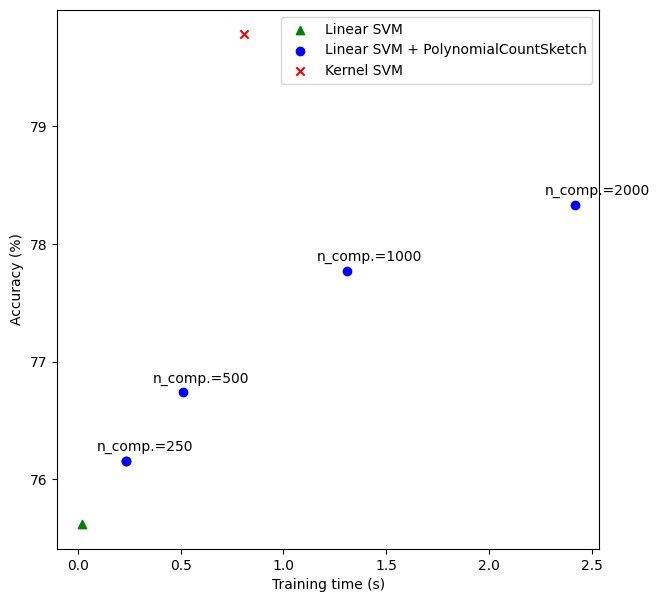

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    [
        results["LSVM"]["time"],
    ],
    [
        results["LSVM"]["score"],
    ],
    label="Linear SVM",
    c="green",
    marker="^",
)

ax.scatter(
    [
        results["LSVM + PS(250)"]["time"],
    ],
    [
        results["LSVM + PS(250)"]["score"],
    ],
    label="Linear SVM + PolynomialCountSketch",
    c="blue",
)

for n_components in N_COMPONENTS:
    ax.scatter(
        [
            results[f"LSVM + PS({n_components})"]["time"],
        ],
        [
            results[f"LSVM + PS({n_components})"]["score"],
        ],
        c="blue",
    )
    ax.annotate(
        f"n_comp.={n_components}",
        (
            results[f"LSVM + PS({n_components})"]["time"],
            results[f"LSVM + PS({n_components})"]["score"],
        ),
        xytext=(-30, 10),
        textcoords="offset pixels",
    )

ax.scatter(
    [
        results["KSVM"]["time"],
    ],
    [
        results["KSVM"]["score"],
    ],
    label="Kernel SVM",
    c="red",
    marker="x",
)

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accuracy (%)")
ax.legend()
plt.show()

# Summary

This lab demonstrated how to use polynomial kernel approximation in scikit-learn to efficiently generate polynomial kernel feature-space approximations. We applied this technique to the Covtype dataset, transforming it into a binary classification problem and training linear classifiers that approximate the accuracy of kernelized ones. We also compared the performance of the different methods and plotted the results against their training times.